In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, deactivate_crossing_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(deactivate_crossing_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, get_max_distance_to_target_surface, get_average_distance_to_target_surface)
from deactivate_crossing_helper import get_segment_index_from_joints
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.12
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('twisted_waffle_1', thickness, width, weaving_dir)
# This is just to get a random surface

0.04 0.0028


In [4]:
io.SUBDIVISION_RESOLUTION = 20

In [5]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

### Initialization

In [6]:
import pickle 
import gzip
# pickle.dump(curved_linkage, gzip.open('{}_{}.pkl.gz'.format(io.MODEL_NAME, time.time()), 'w'))

In [7]:
# curved_linkage = pickle.load(gzip.open('regular_4_7_1607520544.236602.pkl.gz', 'r'))
# curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# curved_linkage_view.show()

In [8]:
# np.save('{}_design_parameters.npy'.format(io.MODEL_NAME), curved_linkage.getDesignParameters())

In [9]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = False, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions()
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

### Stage 1 and manually untwist twisted ribbon

In [10]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()
# curved_linkage.joint(4).set_terminalEdgeNormalSign(10, 1)
# curved_linkage.joint(0).set_terminalEdgeNormalSign(10, 1)
# curved_linkage.joint(15).set_terminalEdgeNormalSign(14, -1)
# curved_linkage.joint(14).set_terminalEdgeNormalSign(14, 1)
# iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0, niter = 400)
# curved_linkage.joint(15).set_terminalEdgeNormalSign(14, 1)
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0, niter = 400)

In [11]:
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0, niter = 400)

In [12]:
bottomColor =[79/255., 158/255., 246/255.]
topColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [13]:
curved_linkage_view.update(scalarField=colors)

In [14]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [15]:
# curved_linkage.setDesignParameters(np.load('{}_design_parameters.npy'.format(io.MODEL_NAME)))

In [16]:
curved_linkage.attraction_weight = 0

In [17]:
# vf = show_selected_joints(curved_linkage, [15, 14], flip = False)
# curved_linkage_view.update(vectorField = vf, scalarField = colors)

In [18]:
# curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))

In [29]:
def eqm_callback(prob, i):
    curved_linkage_view.update(scalarField=colors)

In [30]:
driver=curved_linkage.centralJoint()
jdo = curved_linkage.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with so(): elastic_rods.compute_equilibrium(curved_linkage, fixedVars=fixedVars, callback = eqm_callback, options = OPTS)

In [21]:
# curved_save_tgt_joint_pos = curved_linkage.jointPositions()

In [22]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [23]:
optimizer.scaleJointWeights(1, 1, [])

In [24]:
optimizer.set_holdClosestPointsFixed(True)

In [25]:
optimizer.beta = 1e7

In [26]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, no_surface = True, maxIter = 100)

rl_regularization_weight 0.9999999999999999
smoothing_weight 10.0


Min Width  0.04
Scale:  125.0
num seg per rod 381
num seg per rod 381
num seg per rod 242
0.2


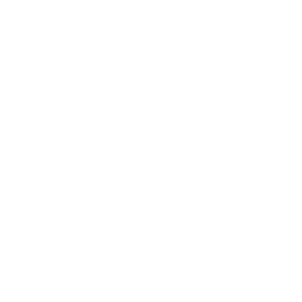

In [27]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)

In [28]:
export_linkage_geometry_to_obj(curved_linkage, '{}_contact_opt.obj'.format(io.MODEL_NAME))

## Contact Optimization

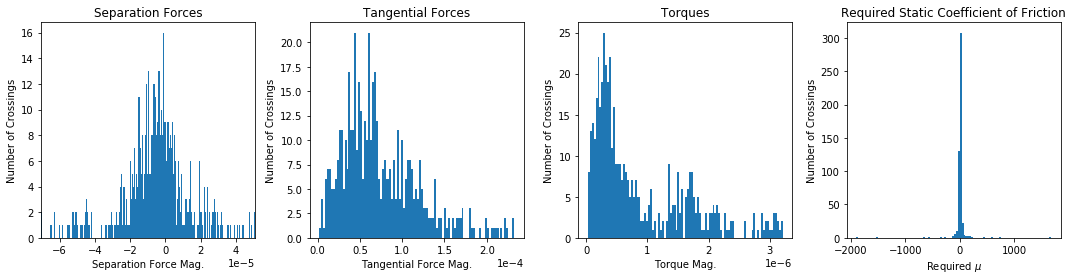

In [31]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [32]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis

In [33]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [448 494 379 447 373 460 416 475 388 376 480 464 433 444 374 472 499 442
 419 469 403 387 479 485 426 427 428 406 468 386 389 429 483 431 409 489
 438 410 439 490 432 407 443   0 367 116 119 120 121 125 128 131 132 133
 134 137 139 140 114 144 149 150 156 157 159 160 163 168 169 174 189 190
 191 147 194 107 103   1   4   6   8  12  15  17  19  21  22  26  27  28
 104  32  39  46  48  56  63  72  81  83  85  89  92  97  99  38 196 197
 203 301 303 304 305 306 307 314 316 318 319 321 322 324 299 325 327 335
 336 339 342 346 348 352 354 355 358 361 363 326 295 288 286 208 210 223
 232 233 234 235 236 237 238 240 241 242 247 248 249 251 252 253 254 255
 256 257 258 275 278 279 280 282 371 250]
0	0.0102725	1.10191	1.10191	1	1
1	0.00285916	1.53225	1.53225	1	1
2	0.00214185	0.134644	0.134644	1	1
3	0.00191976	0.0759855	0.0759855	1	1
4	0.00166447	0.0577378	0.0577378	1	1
5	0.0013973	0.0417306	0.0417306	1	1
6	0.00114653	0.0291887	0.0291887	1	1
7	0.000932358	0.0201743	0.0201743	

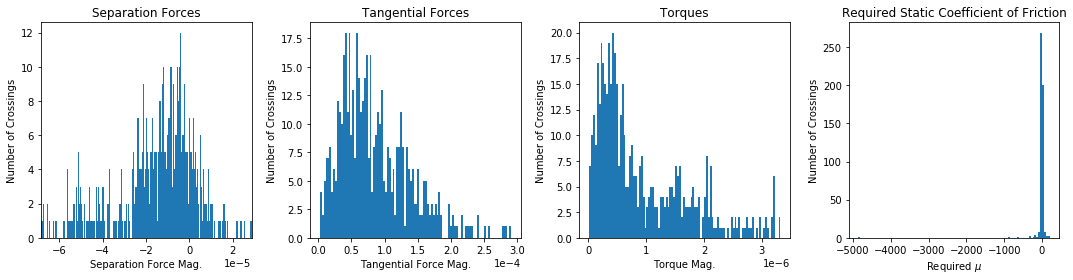

In [34]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [35]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [249  33  18  35 455 500 449 446 496 226  34 207  12 466 485 243  13 463
  11 468  14 461 469 202 246 470 458 471 488  15 472 230 491 130  47 154
 371 308 367 101 364 102 222 104 313 109 377 143 116 347 344 323 120 123
 134 127 132 333 129 350  45 166 391 260 435 434  49 262 429 264 426 266
 424 275 291 413 410 407 406 404 402 400 284 397 286 170  77 412 221]
0	0.00558191	0.721712	0.721712	1	1
1	0.00146509	0.47076	0.47076	1	1
2	0.00117335	0.0550746	0.0550746	1	1
3	0.000972756	0.035461	0.035461	1	1
4	0.000808714	0.0231397	0.0231397	1	1
5	0.000681839	0.0150161	0.0150161	1	1
6	0.000589058	0.00966169	0.00966169	1	1
7	0.000524882	0.00624994	0.00624994	1	1
8	0.000482599	0.00401768	0.00401768	1	1
9	0.000455775	0.00257801	0.00257801	1	1
10	0.000439273	0.00164945	0.00164945	1	1
11	0.000429398	0.00105403	0.00105403	1	1
12	0.00042358	0.000702009	0.000702009	1	1
13	0.000420072	0.000527957	0.000527957	1	1
14	0.000417891	0.000599031	0.000599031	1	1
15	0.000416512	0.000951115	0.00

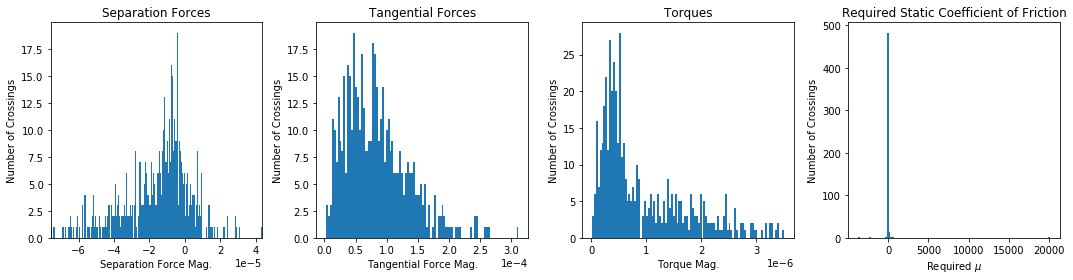

In [36]:
third_structure_view = get_structure_analysis_view(curved_linkage)
third_structure_view.show()

In [39]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [134 344 132  15 341 249 462 498 130 496  31 120 330  11 486 211 243 485
 116  12 476 136  13 482  14 350 347 316 394 367  67  69  70 413 412 411
 410  71  66 389 406 390 404 403 287 391 171 169 407 162 423 426 315 452
 263 264 371  45 446  46  47  50 308 271 377 436 435 434 432 275 429 103
 226]
0	0.00485711	0.646251	0.646251	1	1
1	0.00131347	0.409174	0.409174	1	1
2	0.00106146	0.0517118	0.0517118	1	1
3	0.000888287	0.0327851	0.0327851	1	1
4	0.000747652	0.0212324	0.0212324	1	1
5	0.000639127	0.0136771	0.0136771	1	1
6	0.000560066	0.00870996	0.00870996	1	1
7	0.000505898	0.00553141	0.00553141	1	1
8	0.000470575	0.00349082	0.00349082	1	1
9	0.00044853	0.00219198	0.00219198	1	1
10	0.000435409	0.00136445	0.00136445	1	1
11	0.000427777	0.000862842	0.000862842	1	1
12	0.000423251	0.000598448	0.000598448	1	1
13	0.000420452	0.000475117	0.000475117	1	1
14	0.000418688	0.000546318	0.000546318	1	1
15	0.000417568	0.000717066	0.000717066	1	1
16	0.000416822	0.000997701	0.000997701	1	1
17	

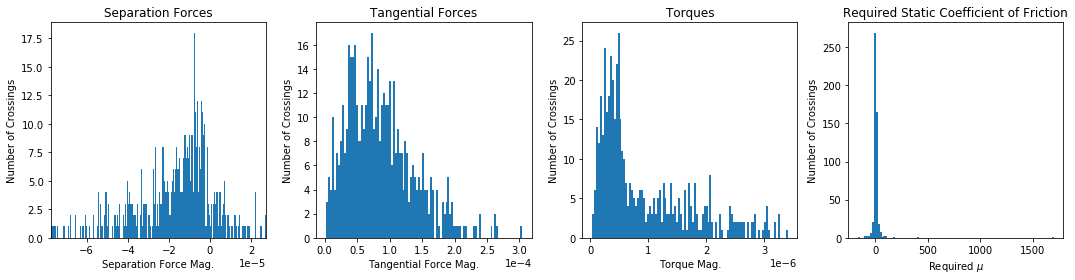

In [40]:
fourth_structure_view = get_structure_analysis_view(curved_linkage)
fourth_structure_view.show()

Min Width  0.05
Scale:  100.0
num seg per rod 12
num seg per rod 12
num seg per rod 6
num seg per rod 6
num seg per rod 12
num seg per rod 12
num seg per rod 6
num seg per rod 6
num seg per rod 6
num seg per rod 6
0.2


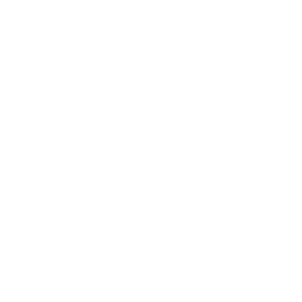

In [33]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_contact_opt', io.RIBBON_NAME + '_contact_opt', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)